## imports

In [1]:
import numpy as np
from numpy import linalg as l
import scipy.integrate as integrate
import matplotlib.pyplot as plt

## initial state

In [2]:
a = 5
k = 1

right_part = np.geomspace(1, a + 1, 1000)
y = np.append(right_part - 1,- right_part + 1)
y = np.unique(y) #np.linspace(-a, a, 1001)
y_ = y.copy() #np.linspace(-a, a, 1001)

Y, Y_ = np.meshgrid(y, y_)

step_y = y - np.roll(y, 1)
step_y_ = np.roll(y, -1) - y
step_y[0] = step_y_[-1] = 0

u = np.tanh(y)
dev2u = - 2 * np.tanh(y) / np.cosh(y) ** 2

min_Y = np.minimum(Y, Y_)
max_Y = np.maximum(Y, Y_)

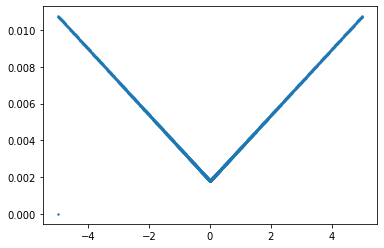

In [3]:
plt.scatter(y, step_y, s=2)

In [4]:
psi_exact = 1 / np.cosh(y)
zeta_exact = -2 / np.cosh(y) ** 3

## functions

In [5]:
def count_eigen(k, a, max_Y, u, min_Y, dev2u, step_y):
    green = - (np.exp(- k * max_Y) - np.exp(- k * (2 * a - max_Y))) \
             * (np.exp(k * min_Y) - np.exp(- k * (2 * a + min_Y))) \
             / (1 - np.exp(- 4 * k * a)) / 2 / k
    kernel = np.diag(u) - (dev2u * green * step_y[:, np.newaxis] + 
                           dev2u * green * step_y_[:, np.newaxis]) / 2
    val, vect = l.eig(kernel)
    return val, vect

In [6]:
def plot_eigen(val, vect, k):
    fig, ax = plt.subplots(figsize=(11, 3))
    
    try: 
        k = k.round(5)
    except:
        k = k
    
    plt.subplot(1, 2, 1)
    plt.scatter(np.real(val), np.imag(val), s=8, alpha=0.7, label=f'k = {k}')
    plt.xlabel('Re(c)')
    plt.ylabel('Im(c)')
    plt.legend(fontsize=8)

    plt.subplot(1, 2, 2)
    vect = vect.T
    idx_complexval1 = np.imag(val).argmax()
    idx_complexval2 = np.imag(val).argmin()
    plt.plot(y, vect[idx_complexval1], label=f'EigVec \n with C={val[idx_complexval1].round(2)}')
    plt.legend(fontsize=8)
    
    return plt.show()

In [7]:
def plot_difference(vals, vect, k):
    eps = 1e-15
    vect = vect.T
    idx_complexval = np.imag(vals).argmax()
    zeta_vect = vect[idx_complexval]
    psi_vect = zeta_vect * (u + eps - vals[idx_complexval]) / (dev2u + eps)
    
    fig, ax = plt.subplots(figsize=(11, 3))

    plt.subplot(1, 2, 1)
    plt.plot(y, zeta_vect, label=f'EigVec with C={vals[idx_complexval].round(2)}')
    plt.plot(y, zeta_exact, label='exact solution')
    plt.xlabel('y')
    plt.ylabel('zeta(y)')
    plt.ylim(-2.1, 1.1)
    plt.legend(loc='upper right', fontsize=8)

    plt.subplot(1, 2, 2)
    vect = vect.T
    idx_complexval = np.imag(vals).argmax()
    plt.plot(y, psi_vect, label=f'psi with C={vals[idx_complexval].round(2)}')
    plt.plot(y, psi_exact, label='exact solution')
    plt.xlabel('y')
    plt.ylabel('psi(y)')
    plt.legend(loc='upper right', fontsize=8)

## stability criteria research

/Users/olaboro/.pyenv/versions/3.7.6/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


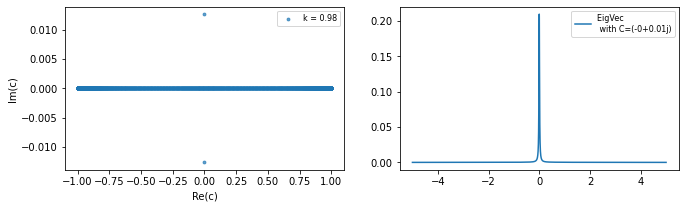

In [8]:
vals, vect = count_eigen(0.98, a, max_Y, u, min_Y, dev2u, step_y)
plot_eigen(vals, vect, 0.98)

In [12]:
imag_vals = []
for k in np.linspace(0.995, 1., 50):
    vals, vect = count_eigen(k, a, max_Y, u, min_Y, dev2u, step_y)
    imag_vals.append((k, np.imag(vals).max()))
    #plot_eigen(vals, vect, k)

In [13]:
imag_vals = np.array(imag_vals)
k_crit = imag_vals.T[0, imag_vals.T[1].argmin()]

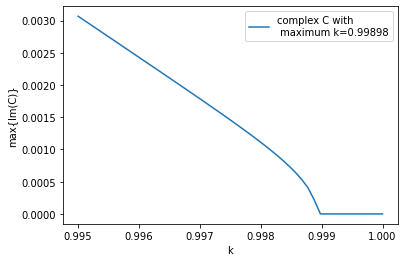

In [14]:
plt.plot(imag_vals.T[0], imag_vals.T[1], label=f'complex C with \n maximum k={k_crit.round(6)}')
plt.xlabel('k')
plt.ylabel('max{Im(C)}')
plt.legend()

## eigenvectors and analytical solution

/Users/olaboro/.pyenv/versions/3.7.6/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


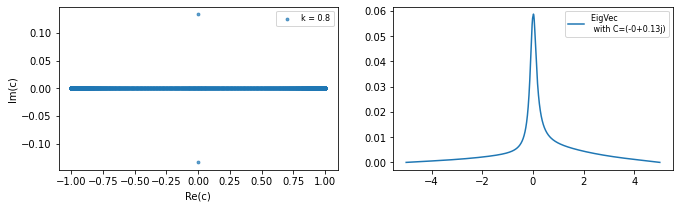

/Users/olaboro/.pyenv/versions/3.7.6/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


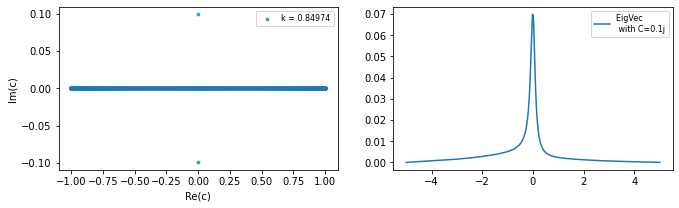

/Users/olaboro/.pyenv/versions/3.7.6/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


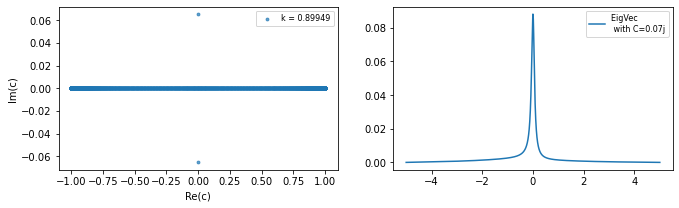

/Users/olaboro/.pyenv/versions/3.7.6/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


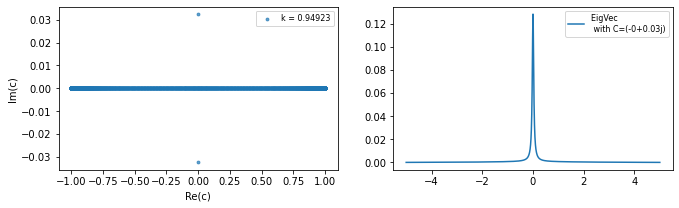

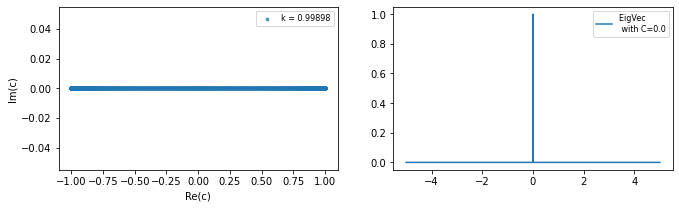

In [15]:
for k in np.linspace(0.8, k_crit, 5):
    vals, vect = count_eigen(k, a, max_Y, u, min_Y, dev2u, step_y)
    plot_eigen(vals, vect, k)

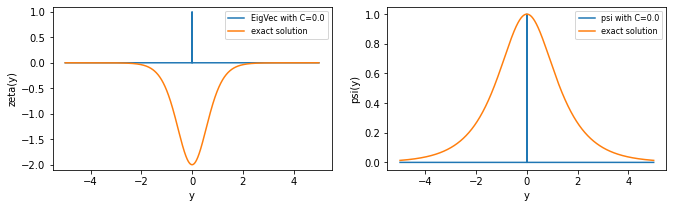

In [16]:
vals, vect = count_eigen(k_crit, a, max_Y, u, min_Y, dev2u, step_y)
plot_difference(vals, vect, k_crit)

/Users/olaboro/.pyenv/versions/3.7.6/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/olaboro/.pyenv/versions/3.7.6/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


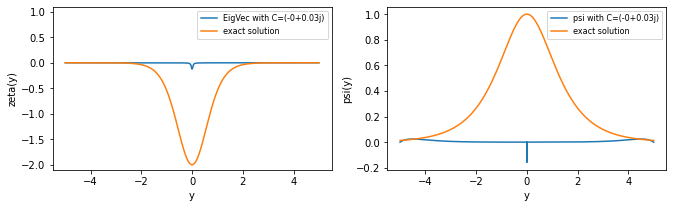

In [17]:
vals, vect = count_eigen(0.94617, a, max_Y, u, min_Y, dev2u, step_y)
plot_difference(vals, vect, 0.94617)